*  This tutorial goes over a basic 2d affinity network using gunpowder (http://funkey.science/gunpowder)

*  Before starting, click "Runtime" in the top panel, select "Change runtime type" and then choose "GPU"

*  This tutorial follows the basic gunpowder tutorial, and is therefore condensed. Check out the basic gunpowder tutorial (**basic_gp_tutorial.ipynb**) if there is any confusion throughout

*  Try running each cell consecutively to see what is happening before changing things around

*  Some cells are collapsed by default, these are generally utility functions or are expanded by defaullt in a previous tutorial. Double click to expand/collapse

*  Sometimes colab can be slow when training, if this happens you may need to restart the runtime. also, you generally can only run one session at a time.

In [1]:
#@title import packages

import gunpowder as gp
import h5py
import io
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import torch
import zarr

from funlib.learn.torch.models import UNet, ConvPass
from gunpowder.torch import Train
from tqdm import tqdm

%matplotlib inline
logging.basicConfig(level=logging.INFO)

In [2]:
#@title utility function to view labels

def create_lut(labels):

    max_label = np.max(labels)

    lut = np.random.randint(
            low=0,
            high=255,
            size=(int(max_label + 1), 3),
            dtype=np.uint8)

    lut = np.append(
            lut,
            np.zeros(
                (int(max_label + 1), 1),
                dtype=np.uint8) + 255,
            axis=1)

    lut[0] = 0
    colored_labels = lut[labels]

    return colored_labels

In [3]:
#@title utility  function to download / save data as zarr

def create_data(
    url, 
    name, 
    offset, 
    resolution,
    sections=None,
    squeeze=True):

  in_f = h5py.File(io.BytesIO(requests.get(url).content), 'r')

  raw = in_f['volumes/raw']
  labels = in_f['volumes/labels/neuron_ids']
  
  container = zarr.open(name, 'a')

  if sections is None:
    sections=range(raw.shape[0]-1)

  for index, section in enumerate(sections):

    print(f'Writing data for section {section}')

    raw_slice = raw[section]
    labels_slice = labels[section]

    if squeeze:
      raw_slice = np.squeeze(raw_slice)
      labels_slice = np.squeeze(labels_slice)

    for ds_name, data in [
        ('raw', raw_slice),
        ('labels', labels_slice)]:
        
        container[f'{ds_name}/{index}'] = data
        container[f'{ds_name}/{index}'].attrs['offset'] = offset
        container[f'{ds_name}/{index}'].attrs['resolution'] = resolution

In [4]:
#lets use the some cremi challenge data as an example, might take a few seconds to download
create_data(
    'https://cremi.org/static/data/sample_A_20160501.hdf',
    'training_data.zarr',
    offset=[0,0],
    resolution=[4,4])

Writing data for section 0
Writing data for section 1
Writing data for section 2
Writing data for section 3
Writing data for section 4
Writing data for section 5
Writing data for section 6
Writing data for section 7
Writing data for section 8
Writing data for section 9
Writing data for section 10
Writing data for section 11
Writing data for section 12
Writing data for section 13
Writing data for section 14
Writing data for section 15
Writing data for section 16
Writing data for section 17
Writing data for section 18
Writing data for section 19
Writing data for section 20
Writing data for section 21
Writing data for section 22
Writing data for section 23
Writing data for section 24
Writing data for section 25
Writing data for section 26
Writing data for section 27
Writing data for section 28
Writing data for section 29
Writing data for section 30
Writing data for section 31
Writing data for section 32
Writing data for section 33
Writing data for section 34
Writing data for section 35
Wr

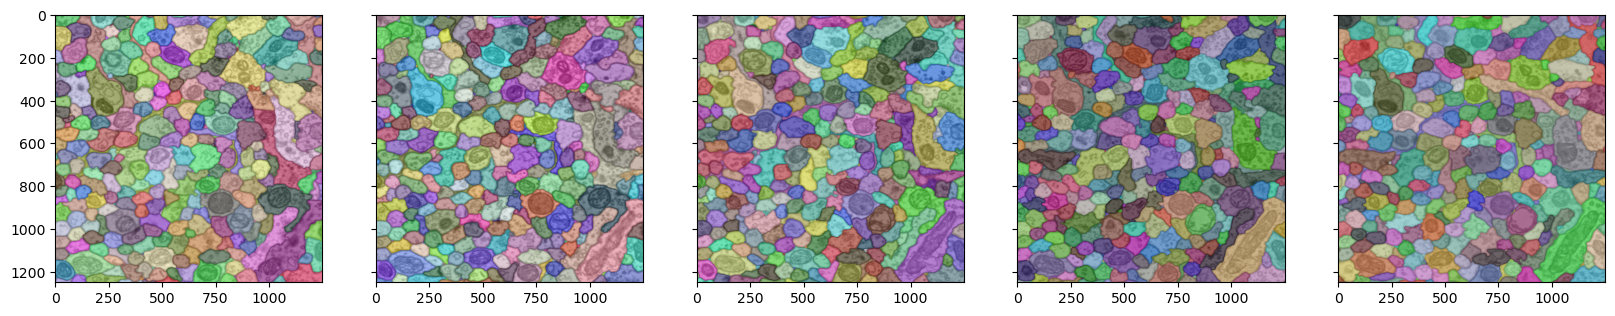

In [5]:
#view the first 5 sections of the volume

fig, axes = plt.subplots(
            1,
            5,
            figsize=(20, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

for i in range(5):
  axes[0][i].imshow(zarr.open('training_data.zarr')[f'raw/{i}'][:], cmap='gray')
  axes[0][i].imshow(create_lut(zarr.open('training_data.zarr')[f'labels/{i}'][:]), alpha=0.5)

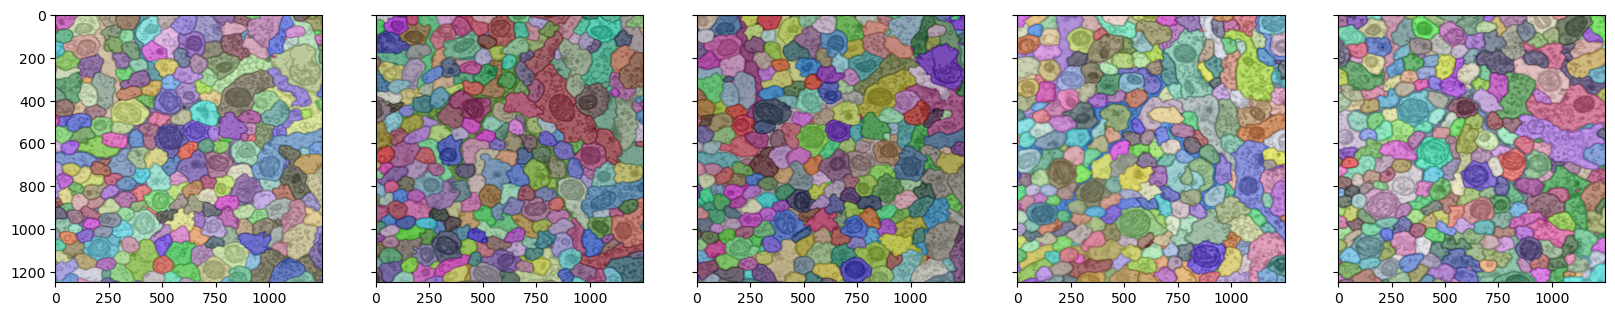

In [6]:
# and a random 5 sections...

fig, axes = plt.subplots(
            1,
            5,
            figsize=(20, 6),
            sharex=True,
            sharey=True,
            squeeze=False)

rand = random.sample(range(0, 124), 5)

for i,j in enumerate(rand):
  axes[0][i].imshow(zarr.open('training_data.zarr')[f'raw/{j}'][:], cmap='gray')
  axes[0][i].imshow(create_lut(zarr.open('training_data.zarr')[f'labels/{j}'][:]), alpha=0.5)

In [7]:
#@title utility function to view a batch

def imshow(
        raw=None,
        ground_truth=None,
        target=None,
        prediction=None,
        h=None,
        shader='jet',
        subplot=True):

    rows = 0

    if raw is not None:
        rows += 1
        cols = raw.shape[0] if len(raw.shape) > 2 else 1
    if ground_truth is not None:
        rows += 1
        cols = ground_truth.shape[0] if len(ground_truth.shape) > 2 else 1
    if target is not None:
        rows += 1
        cols = target.shape[0] if len(target.shape) > 2 else 1
    if prediction is not None:
        rows += 1
        cols = prediction.shape[0] if len(prediction.shape) > 2 else 1

    if subplot:
        fig, axes = plt.subplots(
            rows,
            cols,
            figsize=(10, 4),
            sharex=True,
            sharey=True,
            squeeze=False)

    if h is not None:
        fig.subplots_adjust(hspace=h)

    def wrapper(data,row,name="raw"):
        
        if subplot:
            if len(data.shape) == 2:
                if name == 'raw':
                    axes[0][0].imshow(data, cmap='gray')
                    axes[0][0].set_title(name)
                else:
                    axes[row][0].imshow(create_lut(data))
                    axes[row][0].set_title(name)

            elif len(data.shape) == 3:
                for i, im in enumerate(data):
                    if name == 'raw':
                        axes[0][i].imshow(im, cmap='gray')
                        axes[0][i].set_title(name)
                    else:
                        axes[row][i].imshow(create_lut(im))
                        axes[row][i].set_title(name)
                            
            else:
                for i, im in enumerate(data):
                    axes[row][i].imshow(im[0] + im[1], cmap=shader)
                    axes[row][i].set_title(name)

        else:
            if name == 'raw':
                plt.imshow(data, cmap='gray')
            if name == 'labels':
                plt.imshow(data, alpha=0.5)

    row=0 

    if raw is not None:
        wrapper(raw,row=row)
        row += 1
    if ground_truth is not None:
        wrapper(ground_truth,row=row,name='labels')
        row += 1
    if target is not None:
        wrapper(target,row=row,name='target')
        row += 1
    if prediction is not None:
        wrapper(prediction,row=row,name='prediction')
        row += 1

    plt.show()

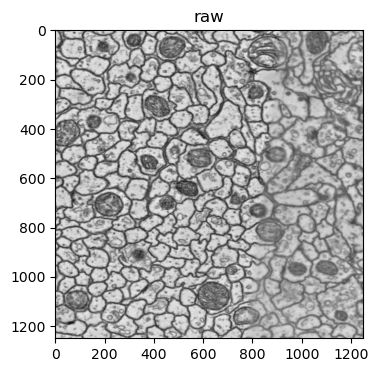

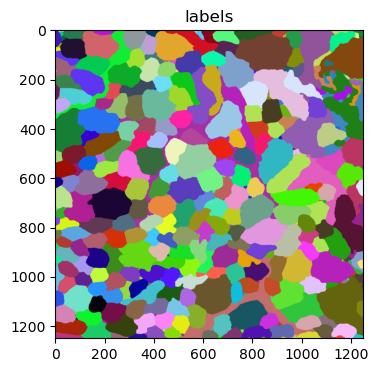

In [8]:
# show 110th section of data using utility func

imshow(raw=zarr.open('training_data.zarr')['raw/110'][:])
imshow(ground_truth=zarr.open('training_data.zarr')['labels/110'][:])

In [9]:
# create gunpowder array keys

raw = gp.ArrayKey('RAW')
labels = gp.ArrayKey('LABELS')
gt_affs = gp.ArrayKey('GT_AFFS')
affs_weights = gp.ArrayKey('AFFS_WEIGHTS')
pred_affs = gp.ArrayKey('PRED_AFFS')

In [10]:
# set voxel size
voxel_size = gp.Coordinate((4, 4))

# our network will have a smaller output shape than input shape
input_shape = gp.Coordinate((164, 164))
output_shape = gp.Coordinate((124, 124))

# convert sizes to world units (i.e nanometers)
input_size = input_shape * voxel_size
output_size = output_shape * voxel_size

In [11]:
# load the first image as a datasource

sources = gp.ZarrSource(
    'training_data.zarr',  
    {
        raw: 'raw/0',
        labels: 'labels/0'
    },  
    {
        raw: gp.ArraySpec(interpolatable=True),
        labels: gp.ArraySpec(interpolatable=False)
    })

# normalize raw data between 0 and 1
sources += gp.Normalize(raw)

# randomly select a patch of the batch shape from the data source 
sources += gp.RandomLocation()

pipeline = sources

print(pipeline)

ZarrSource[training_data.zarr] -> Normalize -> RandomLocation


BATCH 0 DATA


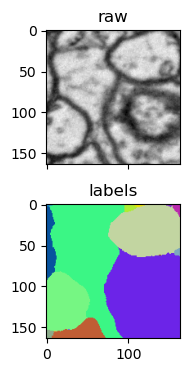



BATCH 1 DATA


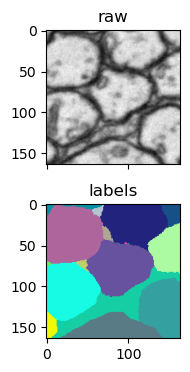



BATCH 2 DATA


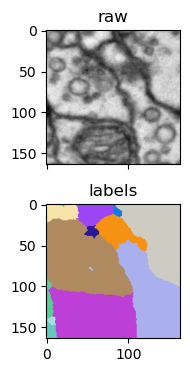

In [12]:
# create a batch request
request = gp.BatchRequest()

# for now let's just check raw data and labels data, and keep the requests the same size since we aren't training yet
request.add(raw, input_size)
request.add(labels, input_size)

# three iterations
for i in range(3):
    with gp.build(pipeline):
        batch = pipeline.request_batch(request)

    print(f'BATCH {i} DATA')

    imshow(
        raw=np.squeeze(batch[raw].data),
        ground_truth=batch[labels].data,
        h=0.3)
    
    print('\n')

In [13]:
# same logic, but for multiple samples. will create a tuple of samples.
# for each sample, normalize the raw data + randomly choose a location
# each tuple entry represents: sample + normalize + random location

num_samples = 5

sources = tuple(
    gp.ZarrSource(
        'training_data.zarr',  
        {
            raw: f'raw/{i}',
            labels: f'labels/{i}'
        },  
        {
            raw: gp.ArraySpec(interpolatable=True),
            labels: gp.ArraySpec(interpolatable=False)
        }) + 
        gp.Normalize(raw) +
        gp.RandomLocation()
        for i in range(num_samples)
    )

print(sources)

(ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation)


In [14]:
# now lets get every available image and change our batch size
num_samples = 124
batch_size = 5

sources = tuple(
    gp.ZarrSource(
        'training_data.zarr',  
        {
            raw: f'raw/{i}',
            labels: f'labels/{i}'
        },  
        {
            raw: gp.ArraySpec(interpolatable=True),
            labels: gp.ArraySpec(interpolatable=False)
        }) + 
        gp.Normalize(raw) +
        gp.RandomLocation()
        for i in range(num_samples)
    )

# our arrays currently have the following shapes:

# raw: (h, w)
# labels: (h, w)

pipeline = sources

# randomly choose a sample from our tuple of samples
pipeline += gp.RandomProvider()

# randomly mirror and transpose a batch
pipeline += gp.SimpleAugment()

# elastically deform the batch
pipeline += gp.ElasticAugment(
    control_point_spacing=(64, 64),
    jitter_sigma=(5.0, 5.0),
    rotation_interval=(0, math.pi/2))

# randomly shift and scale intensities
pipeline += gp.IntensityAugment(
    raw,
    scale_min=0.9,
    scale_max=1.1,
    shift_min=-0.1,
    shift_max=0.1)

# dilate the boundary between labels
pipeline += gp.GrowBoundary(labels)

# calculate ground truth affinities
pipeline += gp.AddAffinities(
    affinity_neighborhood=[
        [0, -1],
        [-1, 0]],
    labels=labels,
    affinities=gt_affs,
    dtype=np.float32)

# no longer need labels since we use the gt affs for training
# our arrays currently have the following shapes:

# raw: (h, w)
# gt_affs: (2, h, w) --> 2 for channel dim because we have x & y affinities. 

# create scale array to balance class losses (will then use the affs_weights array during training)
pipeline += gp.BalanceLabels(
        gt_affs,
        affs_weights)

# pytorch requires tensors with shape (b,c,h,w) for 2d images

# add channel dimension to raw array
pipeline += gp.Unsqueeze([raw])

# our arrays now have shapes:

# raw: (1, h, w)
# gt_affs: (2, h, w)
# affs weights: (2, h, w)

# add batch size
pipeline += gp.Stack(batch_size)

# our arrays now have shapes:

# raw: (b, 1, h, w)
# gt_affs: (b, 2, h, w)
# affs weights: (b, 2, h, w)

In [ ]:
print(np.__version__)
np.bool = np.bool_

1.24.0
<class 'numpy.bool_'>


In [16]:
# create new request
request = gp.BatchRequest()

# we'll make our request sizes correct now to prepare for subsequent training

# our raw data is our input so we need to request the input size
request.add(raw, input_size)

# all other arrays will need to be equal to the output size since our unet has a smaller output size than input size
request.add(labels, output_size)
request.add(gt_affs, output_size)
request.add(affs_weights, output_size)

with gp.build(pipeline):
    batch = pipeline.request_batch(request)

# need to view the raw data in the same roi as labels data
# this is just for matplotlib, so we don't see an offset

start = request[labels].roi.get_begin()/voxel_size
end = request[labels].roi.get_end()/voxel_size

# each column will represent a batch for a single iteration 
    
imshow(
        raw=np.squeeze(batch[raw].data[:,:,start[0]:end[0],start[1]:end[1]]),
        ground_truth=batch[labels].data,
        target=batch[gt_affs].data,
        h=0.3)

/localscratch/conda/envs/lsd-env/lib/python3.10/site-packages/gunpowder/nodes/grow_boundary.py:75: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  foreground = np.zeros(shape=gt.shape, dtype=np.bool)


PipelineRequestError: Exception in pipeline:
(ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation, ZarrSource[training_data.zarr] -> Normalize -> RandomLocation) -> RandomProvider -> SimpleAugment -> ElasticAugment -> IntensityAugment -> GrowBoundary -> AddAffinities -> BalanceLabels -> Unsqueeze -> Stack
while trying to process request

	RAW: ROI: [0:656, 0:656] (656, 656), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	LABELS: ROI: [80:576, 80:576] (496, 496), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	GT_AFFS: ROI: [80:576, 80:576] (496, 496), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	AFFS_WEIGHTS: ROI: [80:576, 80:576] (496, 496), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False


In [ ]:
# we can train now (example using pytorch)
# first, create a custom MSE Loss with weighting

class WeightedMSELoss(torch.nn.MSELoss):

    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, prediction, target, weights):

        scaled = (weights * (prediction - target) ** 2)

        if len(torch.nonzero(scaled)) != 0:

            mask = torch.masked_select(scaled, torch.gt(weights, 0))
            loss = torch.mean(mask)

        else:
            loss = torch.mean(scaled)

        return loss

In [ ]:
# number of input feature maps to the network (will also be number of output feature maps)
num_fmaps = 12

ds_fact = [(2,2),(2,2)]
num_levels = len(ds_fact) + 1
ksd = [[(3,3), (3,3)]]*num_levels
ksu = [[(3,3), (3,3)]]*(num_levels - 1)

# create unet
unet = UNet(
    in_channels=1,
    num_fmaps=num_fmaps,
    fmap_inc_factor=5,
    downsample_factors=ds_fact,
    kernel_size_down=ksd,
    kernel_size_up=ksu,
    constant_upsample=True)

# add an extra convolution to get from 12 feature maps to 2 (affs in x,y)
model = torch.nn.Sequential(
    unet,
    ConvPass(num_fmaps, 2, [[1, 1]], activation='Sigmoid'))

# set loss and optimizer
loss = WeightedMSELoss()
optimizer = torch.optim.Adam(lr=0.5e-4, params=model.parameters())

In [ ]:
# Pre-cache repeated equal batch requests. subsequent requests can be served quickly.
pipeline += gp.PreCache(num_workers=10)

# add a train node
pipeline += Train(
    model,
    loss,
    optimizer,
    inputs={
        'input': raw
    },
    outputs={
        0: pred_affs
    },
    loss_inputs={
        0: pred_affs,
        1: gt_affs,
        2: affs_weights
    })

In [ ]:
request = gp.BatchRequest()

request.add(raw, input_size)
request.add(labels, output_size)
request.add(gt_affs, output_size)
request.add(affs_weights, output_size)
request.add(pred_affs, output_size)

# train to ~1k iterations, view every 100th batch (1001 just to view last batch)
iterations = 1001

with gp.build(pipeline):
    progress = tqdm(range(iterations))
    for i in progress:
        batch = pipeline.request_batch(request)

        start = request[labels].roi.get_begin()/voxel_size
        end = request[labels].roi.get_end()/voxel_size

        if i % 100 == 0:

          imshow(
            raw=np.squeeze(batch[raw].data[:,:,start[0]:end[0],start[1]:end[1]])
          )
          imshow(
            ground_truth=batch[labels].data
          )
          imshow(
            target=batch[gt_affs].data
          )
          imshow(
            prediction=batch[pred_affs].data
          )

        progress.set_description(f'Training iteration {i}') 
        pass

*  Just a general idea of how to use gunpowder - the networks in the paper are all in 3d and should be trained on sufficient hardware

*  Results will probably vary since these are 2d slices of 3d data - sometimes more information is required in the z-dimension to inform predictions (especially for neuron segmentation). Feel free to try training for longer.

*  see how to train lsds in **train_lsds.ipynb**